# DosiPy

In [27]:
import os
import sys
sys.path.append('..')

import numpy as np
try:
    import open3d as o3d
except ImportError:
    print(sys.exc_info())
import pandas as pd
from scipy import interpolate
import quadpy

from dosipy.utils.dataloader import load_ear_data
from dosipy.utils.integrate import elementwise_quad, elementwise_dblquad
from dosipy.utils.viz import (set_colorblind, scatter_2d, scatter_3d,
                              fig_config)

from helpers import (clean_df, export_pcd, export_fields,
                     poynting_vector, export_rect_idx, diff)

In [88]:
# set input data

polarization = 'tm'
f = 26
edge_length = 20
area = edge_length ** 2
origin_dict = {'te@26-400': [-25.28, 17.25],
               'tm@26-400': [-19.77, 5.22],
               'te@60-400': [-25.09, 19.09],
               'te@60-100': [-8.5, 11.38],
               'tm@60-400': [-13.24, 13.05],
               'tm@60-100': [-10.32, 13.46]}

# Surface integration

In [89]:
# load surface data

df = load_ear_data(polarization, f, surface='front')
df = clean_df(df)
xyz = export_pcd(df)
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(xyz)
center = pcd.get_center()
cframe = o3d.geometry.TriangleMesh.create_coordinate_frame(
    size=9, origin=center+np.array([6, -25, -20])
)

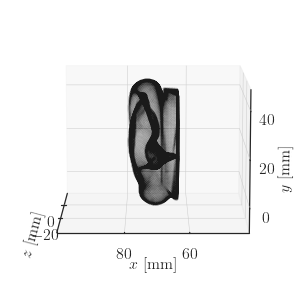

In [90]:
set_colorblind()
fig_config(latex=True, scaler=1.5, text_size=16)
fig, ax = scatter_3d({'$z$ [mm]': xyz[:, 2],
                      '$x$ [mm]': xyz[:, 0],
                      '$y$ [mm]': xyz[:, 1],
                     },
                     alpha=0.0025, elev=[10], azim=[180]
                    )

In [91]:
# postprocessing on the surface of the model

E, H = export_fields(df)
Sx, Sy, Sz = poynting_vector(E, H)

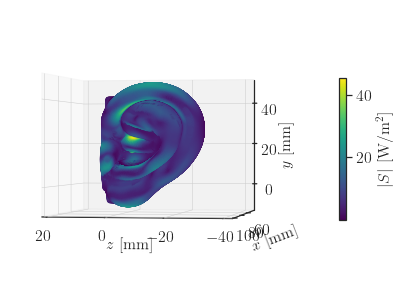

In [92]:
set_colorblind()
label = '$|S|$ [W/m$^2$]'
fig_config(latex=True, scaler=1.5, text_size=16)
fig, ax = scatter_3d({'$z$ [mm]': xyz[:, 2],
                      '$x$ [mm]': xyz[:, 0],
                      '$y$ [mm]': xyz[:, 1],
                      label: np.abs(np.sqrt(Sx ** 2 + Sy ** 2 + Sz ** 2)),
                     },
                     elev=[0], azim=[100]
                    )

In [93]:
# rectangular area for averaging

origin = origin_dict[f'{polarization}@{f}-{area}']
avg_center = [origin[0]+edge_length/2,
              origin[1]+edge_length/2]
area = edge_length ** 2
pAPD_origin, idx_rect = export_rect_idx(xyz=xyz,
                                        center=avg_center,
                                        edge_length=edge_length,
                                        view='zy')
xyz_rect = xyz[idx_rect]
Sx_rect, Sy_rect, Sz_rect = Sx[idx_rect], Sy[idx_rect], Sz[idx_rect]
pcd_rect = o3d.geometry.PointCloud()
pcd_rect.points = o3d.utility.Vector3dVector(xyz_rect)
center_rect = pcd_rect.get_center()

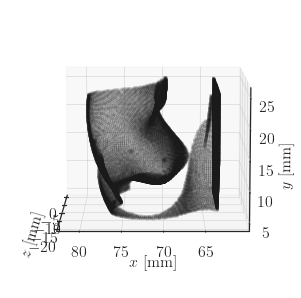

In [94]:
set_colorblind()
fig_config(latex=True, scaler=1.5, text_size=16)
fig, ax = scatter_3d({'$z$ [mm]': xyz_rect[:, 2],
                      '$x$ [mm]': xyz_rect[:, 0],
                      '$y$ [mm]': xyz_rect[:, 1],
                     },
                     alpha=0.1, azim=[-180]
                    )

In [113]:
# extract points visible from the plane wave incidence POV (-x direction)

diameter = np.linalg.norm(
    pcd_rect.get_max_bound() - pcd_rect.get_min_bound()
)
radius = 10 ** 4
camera = [center_rect[0] + diameter, center_rect[1], center_rect[2]]
_, mask = pcd_rect.hidden_point_removal(camera, radius)
xyz_avg = xyz_rect[mask]
Sx_avg, Sy_avg, Sz_avg = Sx_rect[mask], Sy_rect[mask], Sz_rect[mask]
mask = np.where(xyz_avg[:, 0] > 65)[0]
xyz_avg = xyz_avg[mask]
Sx_avg, Sy_avg, Sz_avg = Sx_avg[mask], Sy_avg[mask], Sz_avg[mask]

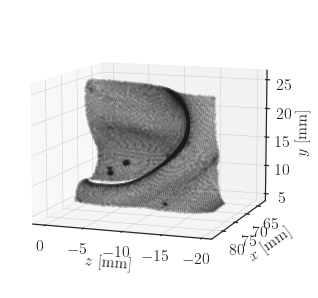

In [114]:
set_colorblind()
fig_config(latex=True, scaler=1.5, text_size=16)
fig, ax = scatter_3d({'$z$ [mm]': xyz_avg[:, 2],
                      '$x$ [mm]': xyz_avg[:, 0],
                      '$y$ [mm]': xyz_avg[:, 1],
                     },
                     alpha=0.1, elev=[10], azim=[-250]
                    )

In [115]:
# approximate x = x(y, z) and compute the length of the normal vector

ds = 1
x_fun = interpolate.Rbf(xyz_avg[::ds, 2], xyz_avg[::ds, 1], xyz_avg[::ds, 0])
x_approximate = x_fun(xyz_avg[:, 2], xyz_avg[:, 1])
np.all(np.isclose(xyz_avg[:, 0], x_approximate))

/home/alk/miniconda3/envs/dosipy/lib/python3.9/site-packages/scipy/interpolate/rbf.py:266: LinAlgWarning: Ill-conditioned matrix (rcond=3.38126e-21): result may not be accurate.
  self.nodes = linalg.solve(self.A, self.di)


True

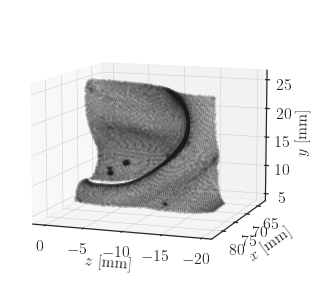

In [116]:
set_colorblind()
fig_config(latex=True, scaler=1.5, text_size=16)
fig, ax = scatter_3d({'$z$ [mm]': xyz_avg[:, 2],
                      '$x$ [mm]': x_approximate,
                      '$y$ [mm]': xyz_avg[:, 1],
                     },
                     alpha=0.1, elev=[10], azim=[-250]
                    )

In [117]:
# approximate the length of the vector field normal to the integration area

dxdz = diff(x_fun, arg=0)
dxdy = diff(x_fun, arg=1)
zy = np.c_[xyz_avg[:, 2], xyz_avg[:, 1]]
n_len = np.sqrt(dxdz(zy) ** 2 + dxdy(zy) ** 2 + 1)

In [118]:
n_len

array([1.11791951, 1.0627573 , 1.38429436, ..., 1.03824573, 1.0398864 ,
       1.03950528])

In [119]:
# compute and orient unit vector normal field

pcd_avg = o3d.geometry.PointCloud()
pcd_avg.points = o3d.utility.Vector3dVector(xyz_avg)
pcd_avg.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamKNN(33))
pcd_avg.orient_normals_consistent_tangent_plane(33)

n_avg = np.asarray(pcd_avg.normals)

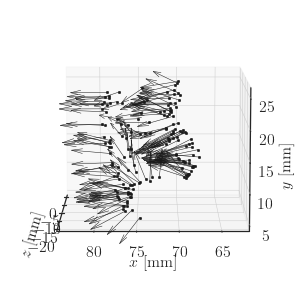

In [120]:
set_colorblind()
fig_config(latex=True, scaler=1.5, text_size=16, line_width=0.5)
fig, ax = scatter_3d({'$z$ [mm]': xyz_avg[::100, 2],
                      '$x$ [mm]': xyz_avg[::100, 0],
                      '$y$ [mm]': xyz_avg[::100, 1],
                     },
                     azim=[180]
                    )
ax.quiver(xyz_avg[::100, 2], xyz_avg[::100, 0], xyz_avg[::100, 1],
          n_avg[::100, 2], n_avg[::100, 0], n_avg[::100, 1], length=5, color='k');

In [124]:
# compute normalized APD distribution

mask = np.where(n_len < 2)[0]
APDn = np.abs(Sx_avg[mask].real * n_avg[mask, 0]
              + Sy_avg[mask].real * n_avg[mask, 1]
              + Sz_avg[mask].real * n_avg[mask, 2]) * n_len[mask]

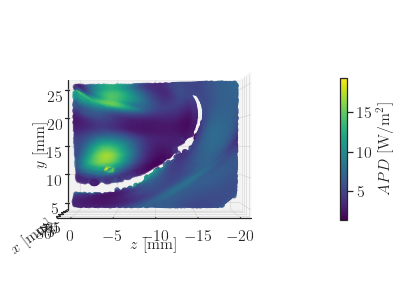

In [125]:
set_colorblind()
label = '$APD$ [W/m$^2$]'
fig_config(latex=True, scaler=1.5, text_size=16)
fig, ax = scatter_3d({'$z$ [mm]': xyz_avg[mask, 2],
                      '$x$ [mm]': xyz_avg[mask, 0],
                      '$y$ [mm]': xyz_avg[mask, 1],
                      label: APDn,
                     },
                     elev=[0], azim=[90]
                    )

In [126]:
# compute area-averaged APD

APDav = elementwise_dblquad(zy[mask], APDn, degree=51,
                            interp_fun=interpolate.LinearNDInterpolator) / area
APDav

/home/alk/miniconda3/envs/dosipy/lib/python3.9/site-packages/scipy/interpolate/rbf.py:266: LinAlgWarning: Ill-conditioned matrix (rcond=2.88253e-21): result may not be accurate.
  self.nodes = linalg.solve(self.A, self.di)


4.916073890345553

# Volumetric integration

In [24]:
# load the volume data for the block of tissue where the front face is the region that yields max APDav

fname_block = os.path.join(os.pardir, 'data', f'loss_3D_ear_{f}GHz_{polarization.upper()}_front.txt')
df_block = (pd.read_csv(fname_block, names=['x [mm]', 'y [mm]', 'z [mm]', 'Pl [W/m^3]'],
                        header=None, delim_whitespace=True, skiprows=[0, 1])
            [lambda x: (x['Pl [W/m^3]'] != 0.0)
                       & (x['y [mm]'] >= xyz_avg[:, 1].min())
                       & (x['y [mm]'] <= xyz_avg[:, 1].max())
                       & (x['z [mm]'] >= xyz_avg[:, 2].min())
                       & (x['z [mm]'] <= xyz_avg[:, 2].max())])
df_block.reset_index(drop=True, inplace=True)

xyz_block = export_pcd(df_block)
Pl_block = df_block['Pl [W/m^3]'].to_numpy()
tissue_density = 1049

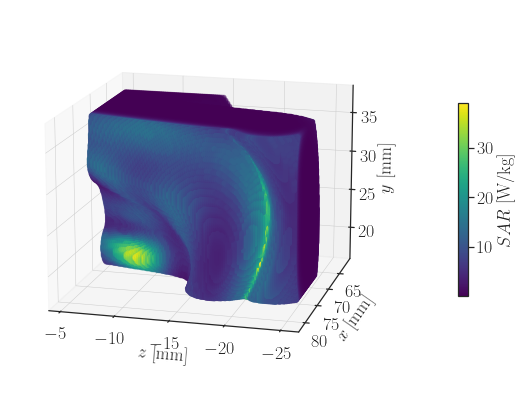

In [25]:
set_colorblind()
fig_config(latex=True, scaler=2, text_size=18)
label = '$SAR$ [W/kg]'
fig, ax = scatter_3d({'$z$ [mm]': xyz_block[:, 2],
                      '$x$ [mm]': xyz_block[:, 0],
                      '$y$ [mm]': xyz_block[:, 1],
                      label: Pl_block / tissue_density},
                      elev=[15], azim=[105])

In [58]:
# compute the TPD distribution by integrating SAR depth-wise (-x direction)

df_rect = df_block.groupby(['y [mm]', 'z [mm]']).apply(
    lambda col: pd.Series({'TPD [W/m^2]': elementwise_quad(col['x [mm]'].to_numpy() / 1000,  # convert to meters
                                                           col['Pl [W/m^3]'].to_numpy(),
                                                           degree=51)})
    ).reset_index()

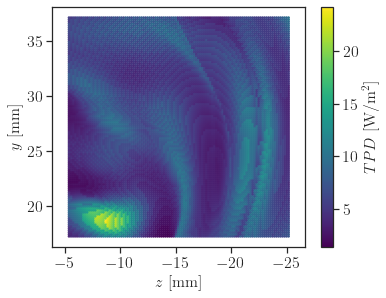

In [59]:
set_colorblind()
fig_config(latex=True, scaler=1.5, text_size=16)
label = '$TPD$ [W/m$^2$]'
fig, ax = scatter_2d({'$z$ [mm]': df_rect['z [mm]'].to_numpy(),
                      '$y$ [mm]': df_rect['y [mm]'].to_numpy(),
                      label: df_rect['TPD [W/m^2]'].to_numpy()}, s=3,
                     figsize=(2.950 * 1.915, 2.950 * 1.5))
ax.invert_xaxis()

In [60]:
# approximate x = x(y, z) and compute the length of the normal vector

xyz_rect = df_block.groupby(['y [mm]', 'z [mm]']).apply(
    lambda col: pd.Series({'x_surf [mm]': col['x [mm]'].max()})
    ).reset_index()
x_fun = interpolate.Rbf(xyz_rect['z [mm]'].to_numpy(),
                        xyz_rect['y [mm]'].to_numpy(),
                        xyz_rect['x_surf [mm]'].to_numpy())
x_approximate = x_fun(xyz_rect['z [mm]'].to_numpy(),
                      xyz_rect['y [mm]'].to_numpy())
np.all(np.isclose(xyz_rect['x_surf [mm]'].to_numpy(), x_approximate))

True

In [86]:
# approximate the length of the vector field normal to the integration area

dxdz = diff(x_fun, arg=0)
dxdy = diff(x_fun, arg=1)
zy = np.c_[xyz_rect['z [mm]'].to_numpy(),
           xyz_rect['y [mm]'].to_numpy()]
n_len = np.sqrt(dxdz(zy) ** 2 + dxdy(zy) ** 2 + 1)
mask = np.where(n_len < 1.3)[0] 

In [87]:
TPD_av = elementwise_dblquad(points=zy[mask],
                             values=df_rect['TPD [W/m^2]'].to_numpy()[mask] * n_len[mask],
                             degree=51,
                             interp_func=interpolate.LinearNDInterpolator, fill_value=0
                            ) / area
TPD_av

7.151730099341744